## Goal Generator

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
class AlternatingGoalGenerator():
    def __init__(self, base_goal_loc_map, next_goal_loc_map):
        self.base_goal_loc_map = base_goal_loc_map
        self.next_goal_loc_map = next_goal_loc_map
        self.is_env_set = False
        self.env = None 
        
    def get_new_location(self, agent_id):
        if not self.is_env_set:
            raise ValueError("Env is not set yet.")
        
        agent_loc = self.env.agent_state[agent_id]
        goal_loc = self.env.agent_goal[agent_id]
        next_goal_loc = self.next_goal_loc_map[goal_loc]
        
        return next_goal_loc
    
    def get_reset_location(self, agent_id):
        next_goal_loc = self.base_goal_loc_map[agent_id]
        return next_goal_loc
        
    def set_env(self, env):
        self.env = env
        self.is_env_set = True


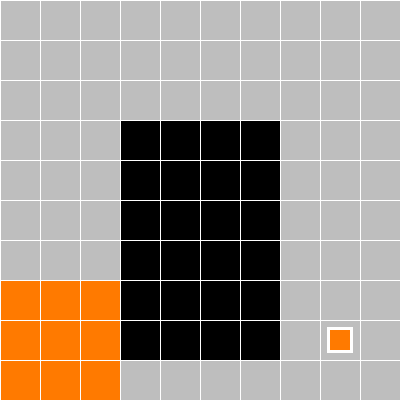

In [5]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np

env_shape = (10,10)

small_world = np.zeros(env_shape)
small_world[3:9, 3:7] = 1
small_agent= np.zeros(env_shape)
small_agent[7:, 0:3] = 1

base_goal_loc_map = {
    0: (8,8),
    1: (8,8),
    2: (8,8),
    3: (8,8),
    4: (8,8),
    5: (8,8),
    6: (8,8),
    7: (8,8),
    8: (8,8),
    9: (8,8),
}
next_goal_loc_map = {
    (8,8): (8,1),
    (8,1): (8,8)
}

goal_generator = AlternatingGoalGenerator(base_goal_loc_map, next_goal_loc_map)

small_env = WarehouseEnv(agent_map=np.array(small_agent), obstacle_map=np.array(small_world), 
                        local_obseration_size=(9,7), render_as_observation=True,
                        goal_generator=goal_generator,
                        delta_tolling=True,
                        delta_tolling_r=0.5,
                        delta_tolling_b=4.0)

small_env.render(zoom_size=40, local=False, draw_grid=True)

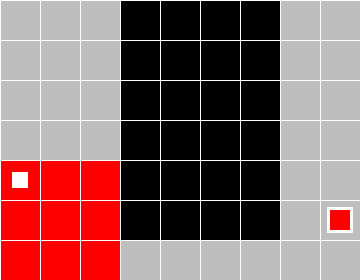

In [5]:
small_env.render(zoom_size=40, local=True, draw_grid=True)

In [75]:
from od_mstar3 import cpp_mstar
import networkx as nx

def get_next_action(env, env_graph, coordinated_planner=False):
    if coordinated_planner:
        states = [(v[0], v[1]) for k, v in env.agent_state.items()]
        goals = [(v[0], v[1]) for k, v in env.agent_goal.items()]
        path = None
        start_x, start_y = None, None
        next_x, next_y = None, None

        try:
            path = cpp_mstar.find_path(env.obstacle_map, states, goals, 10, 5 * 60.0)

            start_x, start_y = env.agent_state[env.current_agent_id]
            next_x, next_y = path[1][env.current_agent_id]   
        except:
            coordinated_planner = False

    if not coordinated_planner:
        location = env.agent_state[env.current_agent_id]
        goal = env.agent_goal[env.current_agent_id]

        path = nx.astar_path(env_graph, (location[0], location[1]), 
                             (goal[0], goal[1]), weight='weight')

        action = None
        start_x, start_y = path[0]
        next_x, next_y = path[1]
        
    if (start_y + 1)  == next_y:
        return_val = 0
    elif (start_y - 1) == next_y:
        return_val = 2
    elif (start_x - 1) == next_x:
        return_val = 1
    elif (start_x + 1) == next_x:
        return_val = 3
    else:
        return_val = 4
    
    return return_val

In [64]:
# Oscillating Goal Generator
small_env.delta_tolling = True
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(10000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action = get_next_action(small_env, small_env.env_graph, coordinated_planner=False)
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_astar_10000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)

In [26]:
#
small_env.delta_tolling = False
# Oscillating Goal Generator
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(1000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action = get_next_action(small_env, small_env.env_graph, coordinated_planner=False)
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_astar_dt=off_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)

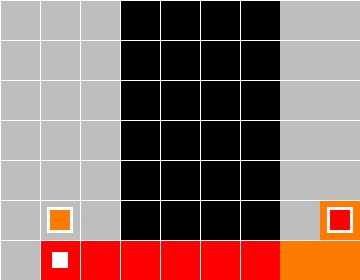

In [28]:
small_env.render(zoom_size=40, agent_id=0, draw_grid=True, local=True)

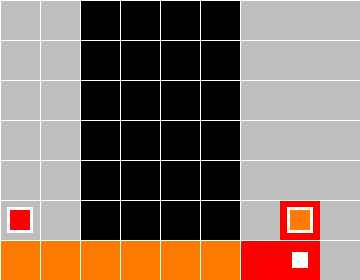

In [37]:
small_env.render(zoom_size=40, agent_id=5, draw_grid=True, local=True)

## RL Agent

In [6]:
from stable_baselines import A2C, A2CWithExperts

model_file = "/Users/pehuen/Downloads/log_14"
a2c_model = A2C.load(model_file + "/model.zip")

/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pehuen/opt/anaconda3/

Loading a model without an environment, this model cannot be trained until it has a valid environment.
self.processed_obs Tensor("input/truediv:0", shape=(?, 28, 36, 3), dtype=float32)
entities: Tensor("model/Reshape:0", shape=(?, 825, 64), dtype=float32)
layerNorm_mean (?, 825, 1)
MHDPA_output Tensor("model/MatMul_1:0", shape=(?, 2, 825, 64), dtype=float32)
residual_output Tensor("model/residualNet/Add:0", shape=(?, 2, 825, 64), dtype=float32)
maxpooling_output Tensor("model/Max:0", shape=(?, 2, 64), dtype=float32)
self.processed_obs Tensor("train_model/input/truediv:0", shape=(?, 28, 36, 3), dtype=float32)
entities: Tensor("train_model/model/Reshape:0", shape=(?, 825, 64), dtype=float32)
layerNorm_mean (?, 825, 1)
MHDPA_output Tensor("train_model/model/MatMul_1:0", shape=(?, 2, 825, 64), dtype=float32)
residual_output Tensor("train_model/model/residualNet/Add:0", shape=(?, 2, 825, 64), dtype=float32)
maxpooling_output Tensor("train_model/model/Max:0", shape=(?, 2, 64), dtype=float32)

In [38]:
#
small_env.delta_tolling = False
# Oscillating Goal Generator
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(1000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action, _states = a2c_model.predict(small_env._observe())#agent_id=0))
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_rl_dt=off_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)


In [47]:
#
small_env.delta_tolling = True
# Oscillating Goal Generator
observation = small_env.reset()
frames = []
old_tolls = {}
for t in range(1000):
    frames.append(small_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action, _states = a2c_model.predict(small_env._observe())#agent_id=0))
    small_env.step(action)
    old_tolls[t] = small_env.toll_map.copy()
    
frames[0].save('gif/goal_generator_animation_rl_dt=on_1000.gif',
               save_all=True, append_images=frames[1:], 
               optimize=False, duration=25, loop=0)


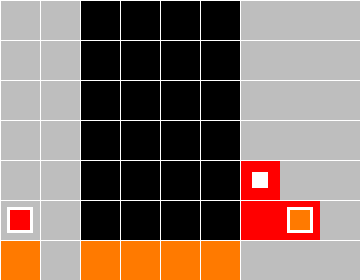

In [50]:
small_env.render(zoom_size=40, agent_id=8, draw_grid=True, local=True)

## Pickup and Delivery Goal Generator
Pickup and delivery goal generator class used with and without delta-tolling

In [6]:
from scipy import spatial

class PickupAndDeliveryGoalGenerator():
    def __init__(self, pickup_goal_loc_list, delivery_goal_loc_list,
                 pickup_distribution, delivery_distribution):
        self.pickup_goal_loc_list = pickup_goal_loc_list
        self.delivery_goal_loc_list = delivery_goal_loc_list
        
        # Make KD Tree for faster lookup
        self.pickup_tree = spatial.KDTree(pickup_goal_loc_list)
        self.delivery_tree = spatial.KDTree(delivery_goal_loc_list)
        
        self.pickup_distribution = pickup_distribution
        self.delivery_distribution = delivery_distribution
        
        # Currently unused but probably should do some sort of load balancing
        self.assigned_pickup_count = {}
        self.assigned_delivery_count = {}
        
        for key in self.pickup_goal_loc_list:
            self.assigned_pickup_count[key] = 0
        
        for key in self.delivery_goal_loc_list:
            self.assigned_delivery_count[key] = 0
        
        self.is_env_set = False
        self.env = None 
        
    def get_new_location(self, agent_id):
        if not self.is_env_set:
            raise ValueError("Env is not set yet.")
            
        agent_loc = self.env.agent_state[agent_id]
        goal_loc = self.env.agent_goal[agent_id]
        
        if agent_loc in self.assigned_pickup_count:
            self.assigned_pickup_count[agent_loc] -= 1
            next_sample = self.delivery_distribution.rvs()
            next_goal_loc = self.delivery_goal_loc_list[ \
                    self.delivery_tree.query(next_sample)[1]]
            self.assigned_delivery_count[next_goal_loc] += 1
            
        elif agent_loc in self.assigned_delivery_count:
            self.assigned_delivery_count[agent_loc] -= 1
            next_sample = self.pickup_distribution.rvs()
            next_goal_loc = self.pickup_goal_loc_list[self.pickup_tree.query(next_sample)[1]]
            self.assigned_pickup_count[next_goal_loc] += 1

        else:
            raise ValueError("Unable to find previous goal location.")
            
        return next_goal_loc
    
    def get_reset_location(self, agent_id):
        goal_loc = self.env.agent_goal[agent_id]
        if goal_loc in self.assigned_pickup_count:
            self.assigned_pickup_count[goal_loc] -= 1
        
        if goal_loc in self.assigned_delivery_count:
            self.assigned_delivery_count[goal_loc] -= 1
        
        next_sample = self.pickup_distribution.rvs()
        next_goal_loc = self.pickup_goal_loc_list[self.pickup_tree.query(next_sample)[1]]
        
        return next_goal_loc
        
    def set_env(self, env):
        self.env = env
        self.is_env_set = True


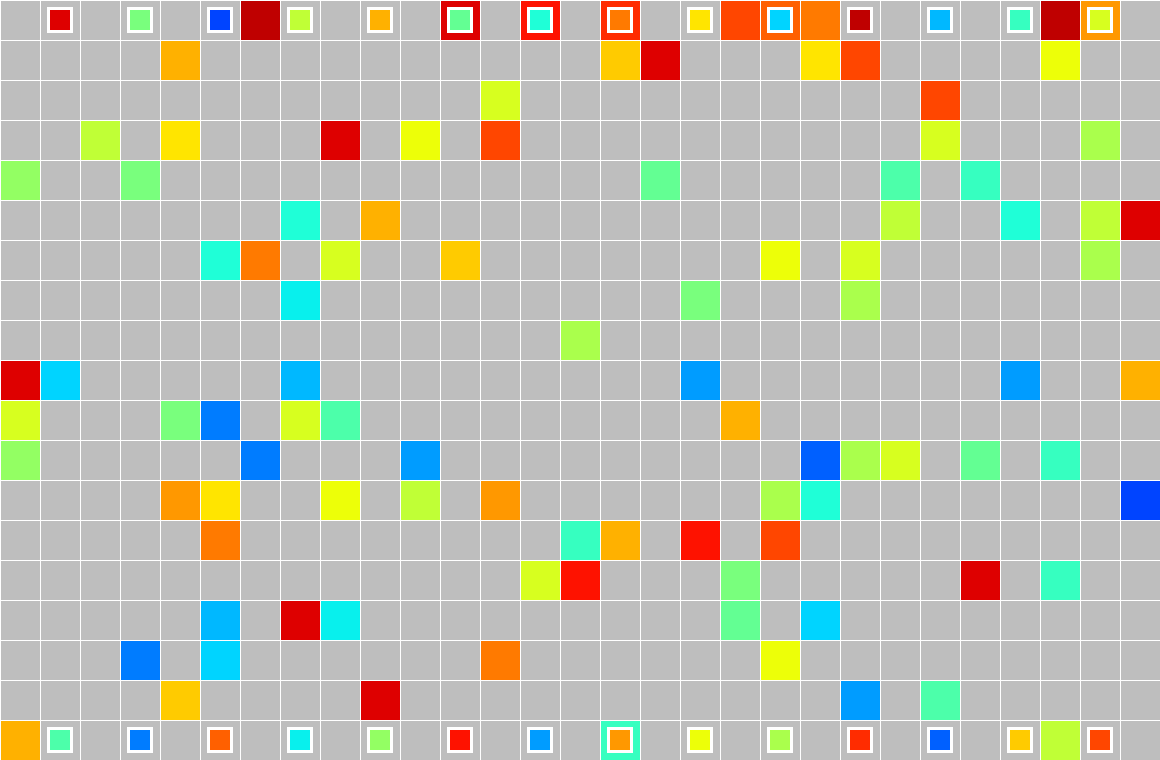

In [7]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np
from scipy.stats import multivariate_normal

env_shape = (19, 29)
num_agents = 100

pd_world = np.zeros(env_shape)
pd_agent= np.random.permutation([1] * num_agents + [0] * 
                (env_shape[0] * env_shape[1] - num_agents)).reshape(env_shape)

def indices_array_generic(m,n):
    r0 = np.arange(m) # Or r0,r1 = np.ogrid[:m,:n], out[:,:,0] = r0
    r1 = np.arange(n)
    out = np.empty((m,n,2),dtype=int)
    out[:,:,0] = r0[:,None]
    out[:,:,1] = r1
    return out

world_indices = indices_array_generic(pd_world.shape[0], pd_world.shape[1])

pickup_array1 = world_indices[-1, 1:-1:2, :]
pickup_array1 = pickup_array1.flatten().reshape(pickup_array1.shape[0], 2)
pickup_array2 = world_indices[0, 1:-1:2, :]
pickup_array2 = pickup_array2.flatten().reshape(pickup_array2.shape[0], 2)
pickup_array = np.concatenate((pickup_array1, pickup_array2)).tolist()

delivery_array = world_indices[int(pd_world.shape[0]/2), 1:-2:2, :]
delivery_array = delivery_array.flatten().reshape(delivery_array.shape[0], 2).tolist()

center_mean = (int(pd_world.shape[0]/2), int(pd_world.shape[1]/2))
center_cov = [[5, 0], [0, 100]]
center_distribution = multivariate_normal(center_mean, center_cov)

goal_generator = PickupAndDeliveryGoalGenerator(list(map(tuple, pickup_array)), 
                                                list(map(tuple, delivery_array)),
                                                center_distribution, center_distribution)

pd_env = WarehouseEnv(agent_map=np.array(pd_agent), obstacle_map=np.array(pd_world), 
                        local_obseration_size=(9,7), render_as_observation=True,
                        goal_generator=goal_generator,
                        delta_tolling=True,
                        delta_tolling_r=0.5,
                        delta_tolling_b=4.0)

pd_env.render(zoom_size=40, local=False, draw_grid=True)

/Users/pehuen/opt/anaconda3/envs/primal2/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


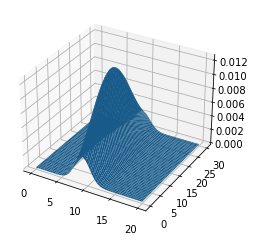

In [8]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
x = np.linspace(0, 20, 100)
y = np.linspace(0, 30, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
center_mean = (int(pd_world.shape[0]/2), int(pd_world.shape[1]/2))
center_cov = [[2, 0], [0, 80]]
rv = multivariate_normal(center_mean, center_cov)
Z = rv.pdf(pos)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
fig.show()

In [10]:
Y

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3030303 ,  0.3030303 ,  0.3030303 , ...,  0.3030303 ,
         0.3030303 ,  0.3030303 ],
       [ 0.60606061,  0.60606061,  0.60606061, ...,  0.60606061,
         0.60606061,  0.60606061],
       ...,
       [29.39393939, 29.39393939, 29.39393939, ..., 29.39393939,
        29.39393939, 29.39393939],
       [29.6969697 , 29.6969697 , 29.6969697 , ..., 29.6969697 ,
        29.6969697 , 29.6969697 ],
       [30.        , 30.        , 30.        , ..., 30.        ,
        30.        , 30.        ]])

In [100]:
#
pd_env.delta_tolling = True
# Oscillating Goal Generator
observation = pd_env.reset()
frames = []
old_tolls = {}
for t in range(10000):
    frames.append(pd_env.render(zoom_size=40, agent_id=None, draw_grid=True, local=False))
    action = get_next_action(pd_env, pd_env.env_graph, coordinated_planner=False)
    pd_env.step(action)
    old_tolls[t] = pd_env.toll_map.copy()
    
frames[0].save('gif/pd_generator_animation_astar_dt=on_10000.gif',
               save_all=True, append_images=frames[1::pd_env.num_agents], 
               optimize=False, duration=5, loop=0)

In [104]:
pd_env.env_graph.edges(data=True)

OutEdgeDataView([((0, 0), (1, 0), {'weight': 0.0}), ((0, 0), (0, 1), {'weight': 0.0}), ((0, 1), (1, 1), {'weight': 0.0}), ((0, 1), (0, 0), {'weight': 0.0}), ((0, 1), (0, 2), {'weight': 0.0}), ((0, 2), (1, 2), {'weight': 0.0}), ((0, 2), (0, 1), {'weight': 0.0}), ((0, 2), (0, 3), {'weight': 0.0}), ((0, 3), (1, 3), {'weight': 0.0}), ((0, 3), (0, 2), {'weight': 0.0}), ((0, 3), (0, 4), {'weight': 0.0}), ((0, 4), (1, 4), {'weight': 0.0}), ((0, 4), (0, 3), {'weight': 0.0}), ((0, 4), (0, 5), {'weight': 0.0}), ((0, 5), (1, 5), {'weight': 0.0}), ((0, 5), (0, 4), {'weight': 0.0}), ((0, 5), (0, 6), {'weight': 0.0}), ((0, 6), (1, 6), {'weight': 0.0}), ((0, 6), (0, 5), {'weight': 0.0}), ((0, 6), (0, 7), {'weight': 0.0}), ((0, 7), (1, 7), {'weight': 0.0}), ((0, 7), (0, 6), {'weight': 0.0}), ((0, 7), (0, 8), {'weight': 0.0}), ((0, 8), (1, 8), {'weight': 0.0}), ((0, 8), (0, 7), {'weight': 0.0}), ((0, 8), (0, 9), {'weight': 0.0}), ((0, 9), (1, 9), {'weight': 0.0}), ((0, 9), (0, 8), {'weight': 1.35525271